In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
import re
from math import sqrt
import string
import json
import os

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import yfinance as yf
import snscrape.modules.twitter as sntwitter

from datetime import datetime
from datetime import date, timedelta

In [ ]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def fetch_stock_details(stock_name, start_date, end_date):

    stock_company = yf.Ticker(stock_name)
    stock_company.info.get("longName")
    stock_data = yf.download(stock_name, start = start_date, end = end_date)
    print("\n Fetched stock data.")

    plt.title('Time series chart of Closing stocks for ' + stock_company.info.get("longName"))
    plt.plot(stock_data["Close"])
    plt.xticks(rotation = 45)

    plt.show()

    stock_data.to_csv(stock_name + '.csv')

In [ ]:
class cleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation)

    def clean_chars(self, text):
        return ''.join([w if ord(w) < 128 else ' ' for w in text])

    def remove_hyperlinks(self,text):
        return ' '.join([w for w in text.split(' ')  if not 'http' in w])

    def clean_text(self, text):
        cleaned_tweet = text.replace('\"','').replace('\'','').replace('-',' ')
        cleaned_tweet =  cleaned_tweet.lower()
        cleaned_tweet =  self.clean_chars(cleaned_tweet)

        if re.match(r'RT @[_A-Za-z0-9]+:',cleaned_tweet):
            cleaned_tweet = cleaned_tweet[cleaned_tweet.index(':')+2:]

        cleaned_tweet = self.remove_hyperlinks(cleaned_tweet)
        cleaned_tweet = cleaned_tweet.replace('#','').replace('@','')

        tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_tweet)]
        tokens = [nltk.WordNetLemmatizer().lemmatize(w) for w in tokens if not w.lower() in self.stop_words and len(w)>1]

        cleaned_tweet = ' '.join(tokens)
        return cleaned_tweet

    def clean_each_tweet(self, tweet, is_bytes = False):
        if is_bytes:
             return self.clean_text(ast.literal_eval(tweet).decode("UTF-8"))
        return self.clean_text(tweet)

In [ ]:
def get_date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def fetch_tweets(stock_name, start_date, end_date, num_tweets):

    csv_file = open('tweets_' + stock_name + '.csv', 'a', encoding="utf-8")
    csvWriter = csv.writer(csv_file, lineterminator= '\n')
    cleanObj = cleaner()

    stock_name = "Tesla"
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.strptime(end_date, '%Y-%m-%d').date()

    print("Collecting tweets ...")
    tweets_list = []
    for single_date in get_date_range(start_date, end_date):

        startdate = single_date.strftime("%Y-%m-%d")
        enddate = datetime.strptime(startdate, '%Y-%m-%d').date() + timedelta(days=1)
        enddate = enddate.strftime("%Y-%m-%d")

        query = stock_name + " since:" + startdate + " until:" + enddate + " lang:en min_faves:50"

        for count, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            if count > num_tweets:
                break

            rawContent = cleanObj.clean_text(tweet.rawContent)
            tweets_list.append([tweet.date.date(), rawContent])

    stock_name = "TSLA"
    tweets_df = pd.DataFrame(tweets_list, columns=['Date', 'Text'])
    tweets_df.to_csv('tweets_' + stock_name + '.csv')
    return tweets_df

In [ ]:
def process_stock_tweets(stock_name):


    df = pd.read_csv('tweets_' + stock_name  + '.csv', encoding='utf-8', names=['Date', 'Text'], header=None)
    df = df.iloc[1:]

    data = df

    data['Prices']=""
    readStockData = pd.read_csv(stock_name + '.csv')
    readStockData.columns = [c.replace(' ', '_') for c in readStockData.columns]

    for i in range (0, len(data)):
        for j in range (0, len(readStockData)):
            get_tweet_date = data.Date.iloc[i]
            get_stock_date = readStockData.Date.iloc[j]

            if(str(get_stock_date)==str(get_tweet_date)):
                data.at[i, 'Prices'] = int(readStockData.Adj_Close[j])
                break


    data['Prices'].replace('', np.nan, inplace=True)
    data.dropna(subset=['Prices'], inplace=True)
    data.reset_index(drop=True, inplace=True)

    data['Prices'] = data['Prices'].apply(np.int64)

    data.to_csv('processed_data_' + stock_name  + '.csv')
    return data

[*********************100%***********************]  1 of 1 completed

 Fetched stock data.


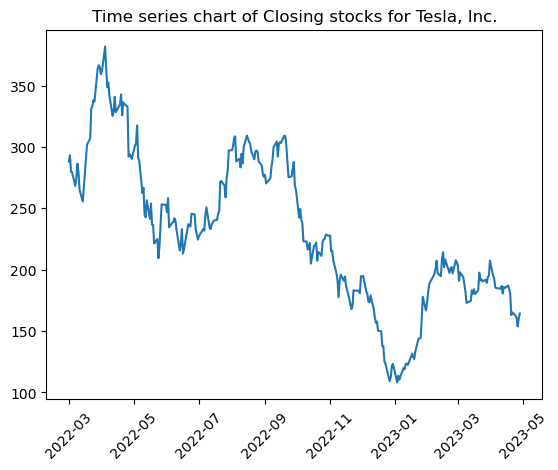

Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d0f18a211b3258'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d033bda54c8bae'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d0205182fd29f7'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d0c4f7845d93d1'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d04e74b7b6d0c2'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d0e31bac61e12f'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d0c520c724d863'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d045cfcfa17d99'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d09aac5cbf3fcc'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d0ea5c7b043032'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d0012656ff82fb'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d0bb981d12d477'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d0ef94c375eb02'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d0f257c91c2312'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d00a7cbd8606c2'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d034bb0d25cd3b'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d070c0cab0f35e'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d09592eff89c3b'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d0c30c8442372e'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d0a1e9c68018fd'
Skipping unrecognised entry ID: 'promoted-tweet-1648689406260441089-6d08aa24cc368e4'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d0d2a5cdc21bbc'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d0b04fa756df8a'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d09dc4f1281c1e'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d0c7edec7ec455'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d0fb735999a7eb'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511143559168-6d098d509d8d179'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d0524de720524b'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d06c45f5a9997e'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d0410fe2f4dd03'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d0e33cba40b89c'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d0e8d1fcd5d685'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d0e86dde5cfff7'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1531a8878ceee'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d1ee6ec06cda9f'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d102693bd7d5fe'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1710e14b7af14'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d17f74da699716'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1968f20eb6123'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-6d1f31df06969a5'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d12b19637c97e8'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d150b556dd3e97'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d1b5e42504ef97'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d168e70cb1cc98'
Skipping unrecognised entry ID: 'promoted-tweet-16544898771304038

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1f503bf11faa9'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-6d1b722f547fa11'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d13a0884f30de5'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1977c88d7ba81'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d1884e8bf4f527'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d11d9f287591d1'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d1cca5f8b349fd'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1058cb2131ad3'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d1594cb15f64a0'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d1528b2c25b7f9'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d19c27d6c26f71'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1d82cb1e9ff62'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d1621892c3bf64'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d1ae45e4d65326'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d160d653a50271'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d15c5de0ee9d8d'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d1f3f8bd37d1e0'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d16182fdaa8712'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d17155584eeee7'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1139e0bec017e'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d12ff10954ecb4'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d156af4f2b6d31'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1d6ff077b8fb8'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511143559168-6d1b4a89373b4a7'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d150aae1141ac3'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d13b9c190daa42'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d1f3e89b178dc3'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d1894d76822b08'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511143559168-6d1e9f236baf7e1'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d1e7e02f4b40b7'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d115344fa4e1fb'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d1e611d6b96951'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d15f05c486dd1f'
Skipping unrecognised entry ID: 'promoted-tweet-16554874500123197

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d286e7205447e4'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d2ed2dfc13e871'
Skipping unrecognised entry ID: 'promoted-tweet-1635745952265805829-6d2096694e6e9d2'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d23ce23bd198f2'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d2cb30abc66402'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d2c1fa37beef0c'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d2362c81c0f5d4'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d246406ca5e8f1'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d288d3147330c4'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d20fdf49aedaa6'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d2e8f18628a050'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d21eda072c6afa'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d2a5b6006087d6'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d254d60c100923'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d29f07cc5c3541'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d2747b1db4d7df'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d26d27a6ba0f71'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d24effd03212de'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d2e1e89d945362'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d2c90824165695'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d239b52527225c'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511143559168-6d2eeb24d959036'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d2a06e0bcb523b'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d2a348064ee62f'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d2a1c9f73c4635'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d2d27b6e81568e'
Skipping unrecognised entry ID: 'promoted-tweet-1648552860039417856-6d2d2fbe35b3863'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d24f4d5bed1219'
Skipping unrecognised entry ID: 'promoted-tweet-1648689406260441089-6d244bc2ae4e8bd'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d263e4318d44b1'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d2607546ced102'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d2617b572937cf'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d2f5e58765c1cb'
Skipping unrecognised entry ID: 'promoted-tweet-16554874500123197

Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d233940d2d9ec1'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d2450f96c529c9'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d20c726ed4d1f2'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d29fe2e203a018'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d2bfc520a8b7bb'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d2b4821ff8ee58'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d29e6baf9fb594'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d20784e3609887'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d2b219be183353'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d22c1673148dd3'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d2387198736705'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d3e408b5e4d1dc'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d36e63f63bc2ed'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d36ea3c536dfa9'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d319e145e190f5'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d3f3f0f8ca88a5'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d3f11cb97d951b'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d335d632c96e39'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d3dca4838e47b9'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d3e007c4d85564'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d39ec6cf3af2ea'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d396a970ed18f1'
Skipping unrecognised entry ID: 'promoted-tweet-16485528600394178

Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d377c2573ce818'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-6d3c548290bf240'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d396930836c3e0'
Skipping unrecognised entry ID: 'promoted-tweet-1654055600060235778-6d361c750df20cb'
Skipping unrecognised entry ID: 'promoted-tweet-1635745952047792129-6d31eb7dba40700'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d3a17cfb5eb632'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d3310c67d3568d'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d371374de041eb'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d32abbd09b0949'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d31173fac31851'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d30141d924846b'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d3e8a3af569f2e'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d35880904aba19'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d33b47a7661dbe'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d3e3b8dcd7f7c6'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d3390983ddb146'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d39d8dd65668d8'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d3aa229a95f016'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d369eeeb5b1ff8'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d3d033213cc3b3'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d3952df992c38f'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d329be00797458'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d339745e686909'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d3bb962d441150'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d3503f2c63ac17'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d38999b704e44e'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d36d448a1587ea'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d3a2c030ff828e'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d31e5692402c3b'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d3af5ec8fff51a'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d34997d6cb3af0'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d3d7a3b2b7e901'
Skipping unrecognised entry ID: 'promoted-tweet-1648552860039417856-6d3cced1845baab'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d47ae0d1534859'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d49535cc8d2001'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d4c983d8bdde38'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d4dc2c3308bf80'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d44e0ed9ed5338'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4c7e11f5a9e8c'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d4b6c2c9c0a0c0'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4d25eab962080'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d4bdba0b18e846'
Skipping unrecognised entry ID: 'promoted-tweet-1654244514297696256-6d4d28655495779'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d4079d4d775a79'
Skipping unrecognised entry ID: 'promoted-tweet-16554874500123197

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d441b729c11168'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d4963338d6f9ab'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d4dda3e0b2214c'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4ae55d38541f6'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4ca0f3fe0fa61'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d4923d77fbcaaf'
Skipping unrecognised entry ID: 'promoted-tweet-1654055600060235778-6d4ad88aead77e1'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d49ea0e0d511c4'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4b07a2342b540'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d46d6e4e6beb59'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d494339caab13d'
Skipping unrecognised entry ID: 'promoted-tweet-16554874499785113

Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d493cbd8fd5176'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d42a927a450100'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4d3b507ac0b10'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d4d30905912411'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d44cd33cc9af53'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d41a3975b3d03c'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d4aaac765a8bbe'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d4ac92f9cd47ee'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4d013de36e0f8'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d4874da7d2b2ba'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d45d840820d1e6'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d45561fcc6c455'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d463588ce8db3a'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d47d70f4eee3de'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d4f3219257c35d'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d44300ad297408'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d460ba02cc7b10'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d4e26f5875cdd0'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d47a53e0ad0b43'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d4646f4aa2ae95'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d422a8cbcb7dda'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d4a0849eccebc1'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1648552860039417856-6d503829de5da4c'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d58adf6c821dad'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d5154585ec074e'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d5a0cb04088982'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d56dd41bc304ff'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d53d6337a1fb44'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d50074deec9232'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d537df02ffa8d6'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d551f7b1144cd1'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d5bfeb1cb8faea'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d5b2e2032093e5'
Skipping unrecognised entry ID: 'promoted-tweet-16554874500123197

Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d54c2d6dd3f1df'
Skipping unrecognised entry ID: 'promoted-tweet-1648552860039417856-6d5114585a813ca'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d55733633b87d4'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d56b3ccf6baf36'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d564a6b3bcaef4'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d5e125fb3b2335'
Skipping unrecognised entry ID: 'promoted-tweet-1648553135735201793-6d51b9c2fcffae1'
Skipping unrecognised entry ID: 'promoted-tweet-1635745952265805829-6d544de24cb6865'
Skipping unrecognised entry ID: 'promoted-tweet-1654244515178516480-6d5fd0d27b0219a'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d5b4860758a34f'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d5e67b3ab60248'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d5f34d2bcd8465'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d544d9f5d67b7c'
Skipping unrecognised entry ID: 'promoted-tweet-1635745952047792129-6d5caea76ca84c3'
Skipping unrecognised entry ID: 'promoted-tweet-1644756994388107267-6d53f5d8e8317b8'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d533a595d999a8'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d5cdb6ccbac29c'
Skipping unrecognised entry ID: 'promoted-tweet-1654244514297696256-6d5298cbd8d3329'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d521da1a09e72b'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d538ecee312ce9'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d511237a2c8f4a'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d5c687e38b70ae'
Skipping unrecognised entry ID: 'promoted-tweet-16486894062604410

Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d66850f3f03e23'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6a6f50f3d6ca2'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d645e84b73a345'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d6b72098d2b5ed'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d65766bf2d460c'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6a683bc9b0b3a'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d6ec5bc2b54bf1'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d64c63f80b3292'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d68c5cf8929f2b'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d66f24497e8e2b'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d68bfa72f9ba51'
Skipping unrecognised entry ID: 'promoted-tweet-16556459003146403

Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d61d46c76dca23'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6b15aa055d59c'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d673535647be7d'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d6707324e132ce'
Skipping unrecognised entry ID: 'promoted-tweet-1654244514297696256-6d644f8689a47a5'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d6b4ea067ae593'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d64a45a6d9a27d'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d69ee934958cae'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d6712c310c85d0'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d649da0f5de861'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d609a14813ed45'
Skipping unrecognised entry ID: 'promoted-tweet-16545762926234214

Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d6f4f6e99408eb'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6890bae607d98'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d63f374b94508e'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d6b1db306e5858'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6f512900fe085'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d6333e93063bf8'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d69f695132f96a'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d601be0900cd5c'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d6a88b801251dd'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d609ad7eb6eeb7'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d6658548e3a951'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d611db6e3ad4ba'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d627fb853edfc3'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6cc5ede3ec9a8'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d6cf6cb0111556'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d65eac441e1fb7'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d6bc99df527c33'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d62952cc72bf95'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-6d68e30b065913b'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6312cb2e77c87'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d6f3542a662d8a'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-6d6e065016993c4'
Skipping unrecognised entry ID: 'promoted-tweet-16554874501338112

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6b79f16ccfacf'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d604604cec0177'
Could not translate t.co card URL on tweet 1629570972536946688
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d693fcb826d31f'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d69bed39537551'
Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d63573ef490c24'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-6d6d4ab7d9f4bd5'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d6d06fc160570d'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d6ac8c4affaf10'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d6c073a265bfc8'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d66cc569457698'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d6315baee7bbef'
Sk

Skipping unrecognised entry ID: 'promoted-tweet-1654487109346947072-6d7d0400f690418'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d71e3c28acc009'
Skipping unrecognised entry ID: 'promoted-tweet-1654576292623421440-6d7f6f0e803c4ee'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d76e8b57c745fb'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d7c36275801c09'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d7494a99a8eeb5'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d759c413ee849a'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d765f62db5d70f'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d7a52e3e2404d7'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d7a1f1db1e0fb9'
Skipping unrecognised entry ID: 'promoted-tweet-1651032127964684290-6d7cfb489e5c677'
Skipping unrecognised entry ID: 'promoted-tweet-16554874500123197

Skipping unrecognised entry ID: 'promoted-tweet-1654244509985677316-6d7118a32f7b218'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d79a5bf4345cc8'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d7b7e28866745d'
Skipping unrecognised entry ID: 'promoted-tweet-1654055600060235778-6d75d343cca48ac'
Skipping unrecognised entry ID: 'promoted-tweet-1654244511294570496-6d7b6f927394244'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d72aadd2caf48c'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d74c2f56d52b7b'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d7883f7157131b'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d7fd365522382c'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d72bcdf04298b2'
Skipping unrecognised entry ID: 'promoted-tweet-1648552860039417856-6d75873e7cfdd8d'
Skipping unrecognised entry ID: 'promoted-tweet-16542445111435591

Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d7151327844b68'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d75f01f8cce0a2'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d7f04f4ae8224a'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d7c5be9e2f28e3'
Skipping unrecognised entry ID: 'promoted-tweet-1648552860039417856-6d782ab4fc2d9a3'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d73e4e0170886c'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d72220ff2c6bb4'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d70010da157092'
Skipping unrecognised entry ID: 'promoted-tweet-1654489877130403845-6d72bea50bf18fb'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d7d55c563adfaa'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d72e1f3a53d599'
Skipping unrecognised entry ID: 'promoted-tweet-16542445142976962

Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d7389150454174'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d766a121fead5c'
Skipping unrecognised entry ID: 'promoted-tweet-1599815537210564610-6d724afbc2e9529'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450133811200-6d710fba6d50c7c'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d7df760de77cbe'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d735361ea90bf0'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d74ec38a5f48da'
Skipping unrecognised entry ID: 'promoted-tweet-1655487449978511360-6d7548c217070e9'
Skipping unrecognised entry ID: 'promoted-tweet-1627239117452103681-6d712f3430c9705'
Skipping unrecognised entry ID: 'promoted-tweet-1655645900314640384-6d7e6d60b4ca2fc'
Skipping unrecognised entry ID: 'promoted-tweet-1655487450012319744-6d74e40cd4e14da'
Skipping unrecognised entry ID: 'promoted-tweet-16272391174521036

,Date,Text
0,2022-03-01,every try piss tesla fan like reward
1,2022-03-01,cchanelsavage mrknowitalll wig shorter length ...
2,2022-03-01,telling action use take tesla fsd self driving...
3,2022-03-01,seriously well needed sip tesla tequila last b...
4,2022-03-01,imagine q2 2023 earnings day tesla record prod...
...,...,...
17461,2023-04-30,tesla full self driving beta 1136 already driv...
17462,2023-04-30,hyundai ioniq v tesla model would pick
17463,2023-04-30,car general used people express one life thus ...
17464,2023-04-30,elonmusk tesla use clean balance sheet extendi...


In [ ]:
start_date = "2022-03-01"
end_date = "2023-05-01"
stock_name = "TSLA"

fetch_stock_details(stock_name, start_date, end_date)

fetch_tweets(stock_name, start_date, end_date, 40)

In [ ]:
stock_name = "TSLA"
process_stock_tweets(stock_name)

,Date,Text,Prices
0,2022-03-01,every try piss tesla fan like reward,288
1,2022-03-01,cchanelsavage mrknowitalll wig shorter length ...,288
2,2022-03-01,telling action use take tesla fsd self driving...,288
3,2022-03-01,seriously well needed sip tesla tequila last b...,288
4,2022-03-01,imagine q2 2023 earnings day tesla record prod...,288
...,...,...,...
12008,2023-04-28,realmeetkevin tesla elonmusk great meeting rea...,164
12009,2023-04-28,realmeetkevin gordonjohnson19 tesla elonmusk g...,164
12010,2023-04-28,flew gordonjohnson19 house confront tesla elon...,164
12011,2023-04-28,ancient focus issue brother tesla today go sai...,164


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [ ]:
stock_name = "TSLA"
tweets = pd.read_csv('processed_data_' + stock_name  + '.csv')
tweets.head()

,Unnamed: 0,Date,Text,Prices
0,0,2022-03-01,every try piss tesla fan like reward,288
1,1,2022-03-01,cchanelsavage mrknowitalll wig shorter length ...,288
2,2,2022-03-01,telling action use take tesla fsd self driving...,288
3,3,2022-03-01,seriously well needed sip tesla tequila last b...,288
4,4,2022-03-01,imagine q2 2023 earnings day tesla record prod...,288


In [ ]:
tweets['word_count'] = tweets['Text'].apply(lambda x: len(x.split()))
tweets = tweets[tweets['word_count'] <= 30]
tweets = tweets.drop('word_count', axis=1)

In [ ]:
tweets.shape

(11482, 4)

In [ ]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


('cardiffnlp/twitter-xlm-roberta-base-sentiment\\tokenizer_config.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\special_tokens_map.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\sentencepiece.bpe.model',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\added_tokens.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\tokenizer.json')

In [ ]:
def get_polarity(text):
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    l = config.id2label[ranking[0]]

    if l == "positive":
        polarity = 1
    elif l == "negative":
        polarity = -1
    elif l == "neutral":
        polarity = 0

    s = np.round(float(scores[ranking[0]]), 4)
    return (l, polarity)

In [ ]:
tweets['label'], tweets['Polarity'] = zip(*tweets['Text'].apply(lambda txt:get_polarity(txt)))
stock_name = "TSLA"
tweets.to_csv('polarized_' + stock_name  + '.csv', index=False)

In [ ]:
stock_name = "TSLA"
polarized_tweets = pd.read_csv('polarized_' + stock_name  + '.csv')
polarized_tweets.shape

(11482, 6)

In [ ]:
polarized_tweets.head()

,Unnamed: 0,Date,Text,Prices,label,Polarity
0,0,2022-03-01,every try piss tesla fan like reward,288,negative,-1
1,1,2022-03-01,cchanelsavage mrknowitalll wig shorter length ...,288,neutral,0
2,2,2022-03-01,telling action use take tesla fsd self driving...,288,neutral,0
3,3,2022-03-01,seriously well needed sip tesla tequila last b...,288,neutral,0
4,4,2022-03-01,imagine q2 2023 earnings day tesla record prod...,288,neutral,0


In [ ]:
polarized_tweets['Date'] = pd.to_datetime(polarized_tweets['Date'],infer_datetime_format=True)
polarized_tweets['Date'] = pd.to_datetime(polarized_tweets['Date'].dt.strftime("%m/%d/%y"))

polarity_df = pd.DataFrame(polarized_tweets.groupby('Date')['Polarity'].mean())
polarity_df.rename(columns = {"Polarity":"P_mean"}, inplace=True)

polarity_df['P_sum'] = polarized_tweets.groupby('Date')['Polarity'].sum()
polarity_df['twt_count'] = polarized_tweets.groupby('Date')['Polarity'].count()
polarity_df.head(10)

,P_mean,P_sum,twt_count
Date,,,
2022-03-01,0.000000,0,39
2022-03-02,-0.263158,-10,38
2022-03-03,-0.341463,-14,41
2022-03-04,0.051282,2,39
2022-03-07,-0.150000,-6,40
2022-03-08,-0.102564,-4,39
2022-03-09,-0.121951,-5,41
2022-03-10,-0.175000,-7,40
2022-03-11,-0.075000,-3,40


In [ ]:
stock_name = "TSLA"
tsla_df = pd.read_csv(stock_name  + '.csv')
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'],infer_datetime_format=True)
tsla_df.set_index("Date")
final_df = tsla_df.join(polarity_df,on='Date',how="inner")
final_df.rename(columns={"Date" : "date"}, inplace = True)
final_df.head(10)

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2022-03-01,289.893341,296.626678,284.593323,288.123322,288.123322,74766900,0.000000,0,39
1,2022-03-02,290.709991,295.493347,281.423340,293.296661,293.296661,74643300,-0.263158,-10,38
2,2022-03-03,292.923340,295.480011,277.533325,279.763336,279.763336,61623600,-0.341463,-14,41
3,2022-03-04,283.033325,285.216675,275.053345,279.429993,279.429993,66999600,0.051282,2,39
4,2022-03-07,285.433319,288.713318,268.190002,268.193329,268.193329,72494100,-0.150000,-6,40
5,2022-03-08,265.176666,283.329987,260.723328,274.799988,274.799988,80399100,-0.102564,-4,39
6,2022-03-09,279.826660,286.853333,277.336670,286.323334,286.323334,59184000,-0.121951,-5,41
7,2022-03-10,283.816681,284.816681,270.119995,279.433319,279.433319,58648500,-0.175000,-7,40
8,2022-03-11,280.066681,281.266663,264.589996,265.116669,265.116669,67037100,-0.075000,-3,40
9,2022-03-14,260.203339,266.899994,252.013336,255.456665,255.456665,71152200,-0.325000,-13,40


In [ ]:
final_df.to_csv(stock_name  + '_data.csv', index=False)